# Clustering with Text

**OBJECTIVES**:

- Use clustering on text data to surface similar texts.
- Use different distance metrics to determine clusters.
- Understand partitive clustering on text
- Augment `sklearn` clustering algorithms to fit in pipeline


### Problem: What Constitutes Similarity?
 



In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.base import BaseEstimator, TransformerMixin

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
#custom class for pipeline
class KMCluster(BaseEstimator, TransformerMixin):
    #what happens when instantiated -- 
    #when instantianted we will create a KMeans object with 4 centers
    def __init__(self, k = 4): 
        self.k = k
        self.model  = KMeans(n_clusters= self.k, random_state = 22)
    #placeholder for sklearn consistency 
    def fit(self, documents, labels = None):
        return self
    #where the action happens and we cluster our documents
    def transform(self, documents):
        return self.model.fit_predict(documents)
        

In [8]:
kmeans = KMCluster()

In [9]:
#use newsgroups data
from sklearn.datasets import fetch_20newsgroups

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [10]:
news = fetch_20newsgroups(categories = ['rec.sport.baseball', 'rec.sport.hockey', 'rec.motorcycles', 'rec.autos'])

In [11]:
#X = ...
X = news.data

In [12]:
#instantiate
kmeans = KMCluster()

In [13]:
#fit it
kmeans.fit(X)

KMCluster()

In [14]:
#get labels with .transform()
kmeans.transform(X)

ValueError: could not convert string to float: 'From: swdwan@napier.uwaterloo.ca (Donald Wan)\nSubject: $ 80 SVX OIL CHANGE\n \nOrganization: University of Waterloo\nLines: 17\n\n\n\n\n\n My friend brought a subaru SVX recently.  I had drove it for couples times and I\nthink its a great car, esp on snow.  However when she took it to a local Subaru\ndealer for a oil change, the bill came out to be about 80 dollars.  The dealer\ntold us it is because to change the oil filter on a SVX it is necessary to\ndisassemble a metal cover under the engine and that took an hour of labour.\nAt first, we think we are being ripped off so she phone to a dealer in Toronto\nbut found out the they are charging roughly the same price.  So is there any\nSVX owner out there that has the same problem ?  And if the oil change story is\ntrue, then the engineer of Subaru looks pretty stubid to me. By the way, the car\nlooks great.\n\nSWD Wan.\n\n'

In [15]:
print(X[0])

From: swdwan@napier.uwaterloo.ca (Donald Wan)
Subject: $ 80 SVX OIL CHANGE
 
Organization: University of Waterloo
Lines: 17





 My friend brought a subaru SVX recently.  I had drove it for couples times and I
think its a great car, esp on snow.  However when she took it to a local Subaru
dealer for a oil change, the bill came out to be about 80 dollars.  The dealer
told us it is because to change the oil filter on a SVX it is necessary to
disassemble a metal cover under the engine and that took an hour of labour.
At first, we think we are being ripped off so she phone to a dealer in Toronto
but found out the they are charging roughly the same price.  So is there any
SVX owner out there that has the same problem ?  And if the oil change story is
true, then the engineer of Subaru looks pretty stubid to me. By the way, the car
looks great.

SWD Wan.




### Using a Pipeline

Now, we get our `KMClusters` in a pipeline that vectorizes the texts and passes through the clusterer.

In [16]:
#bring in pipeline and vectorizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [17]:
#make the pipeline
kmeans_pipe = make_pipeline(CountVectorizer(stop_words='english', max_features = 500),
                            StandardScaler(with_mean = False), KMCluster())

In [18]:
#fit the pipe
kmeans_pipe.fit(X)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=500, stop_words='english')),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('kmcluster', KMCluster())])

In [20]:
#get the labels
labels = kmeans_pipe.transform(X)

In [23]:
#look at the class representation
x, y = np.unique(labels, return_counts=True)

<BarContainer object of 4 artists>

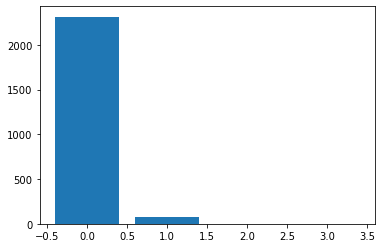

In [24]:
plt.bar(x, y)

### The NLTK Cluster Module

*Advantages*: Here we can make use of the `cosine_distance` which can be more effective for clustering texts.

In [25]:
#import the clusterer and distance metric
from nltk.cluster import KMeansClusterer, cosine_distance

In [26]:
#write our new clustom nltk class
class NLTKClusterer(BaseEstimator, TransformerMixin):
    
    def __init__(self, k = 4):
        self.k = k
        self.distance = cosine_distance
        self.model = KMeansClusterer(num_means = self.k, distance = self.distance,
                                    avoid_empty_clusters=True)
        
    def fit(self, documents, labels = None):
        return self
    
    def transform(self, documents):
        return self.model.cluster(documents.toarray(), assign_clusters = True)

In [31]:
#new pipe
nltk_pipe = make_pipeline(CountVectorizer(max_features=500, stop_words='english'), 
                          NLTKClusterer())

In [32]:
#fit it
nltk_pipe.fit(X)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=500, stop_words='english')),
                ('nltkclusterer', NLTKClusterer())])

In [33]:
#extract labels
nltk_labels = nltk_pipe.transform(X)

<BarContainer object of 4 artists>

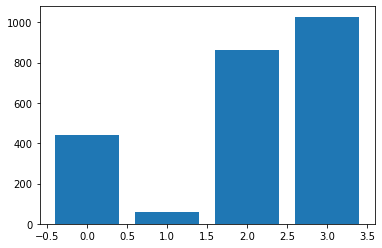

In [34]:
#plot the results
cluster, nltk_counts  = np.unique(nltk_labels, return_counts=True)
plt.bar(cluster, nltk_counts)

In [35]:
#there is a subject line
X[0].split('\n')[1]

'Subject: $ 80 SVX OIL CHANGE'

In [36]:
#make a news dataframe
newsdf = pd.DataFrame(X)

In [37]:
newsdf.head()

,0
0,From: swdwan@napier.uwaterloo.ca (Donald Wan)\...
1,From: etxonss@ufsa.ericsson.se (Staffan Axelss...
2,From: larry@boris.webo.dg.com (Larry Rogers)\n...
3,From: sepinwal@mail.sas.upenn.edu (Alan Sepinw...
4,From: napoli@strobe.ATC.Olivetti.Com (Gaetano ...


In [38]:
#add column label
newsdf.columns = ['text']

In [40]:
#add label column
newsdf['labels'] = nltk_labels

In [41]:
#make a function to grab subjects
newsdf.head()

,text,labels
0,From: swdwan@napier.uwaterloo.ca (Donald Wan)\...,2
1,From: etxonss@ufsa.ericsson.se (Staffan Axelss...,1
2,From: larry@boris.webo.dg.com (Larry Rogers)\n...,2
3,From: sepinwal@mail.sas.upenn.edu (Alan Sepinw...,3
4,From: napoli@strobe.ATC.Olivetti.Com (Gaetano ...,2


In [ ]:
#extract subjects as new column


In [44]:
#group by the labels
newsdf.groupby('labels').head(2).values

array([['From: swdwan@napier.uwaterloo.ca (Donald Wan)\nSubject: $ 80 SVX OIL CHANGE\n \nOrganization: University of Waterloo\nLines: 17\n\n\n\n\n\n My friend brought a subaru SVX recently.  I had drove it for couples times and I\nthink its a great car, esp on snow.  However when she took it to a local Subaru\ndealer for a oil change, the bill came out to be about 80 dollars.  The dealer\ntold us it is because to change the oil filter on a SVX it is necessary to\ndisassemble a metal cover under the engine and that took an hour of labour.\nAt first, we think we are being ripped off so she phone to a dealer in Toronto\nbut found out the they are charging roughly the same price.  So is there any\nSVX owner out there that has the same problem ?  And if the oil change story is\ntrue, then the engineer of Subaru looks pretty stubid to me. By the way, the car\nlooks great.\n\nSWD Wan.\n\n',
        2],
       ['From: etxonss@ufsa.ericsson.se (Staffan Axelsson)\nSubject: NHL Swedes: Stats, Apr

In [ ]:
#examine the first two results from each group


### Make it faster

Write a new custom class to utilize `sklearn`'s minibatch implementation and compare its training time to that of the earlier KMeans and NLTK implementation.

### Agglomerative Clustering

<center>
<img src = https://upload.wikimedia.org/wikipedia/commons/thumb/9/97/Orange-data-mining-hierarchical-clustering.png/440px-Orange-data-mining-hierarchical-clustering.png />
</center>

In [45]:
#imports
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [51]:
#custom class
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

class HierarchicalClusterer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.model = AgglomerativeClustering()
        
    def fit(self, documents, labels = None):
        return self
    
    def transform(self, documents):
        clusters = self.model.fit(documents.toarray())
        
        self.labels_ = self.model.labels_
        self.children_ = self.model.children_
        
        return clusters

In [52]:
#pipeline
h_pipe = make_pipeline(CountVectorizer(stop_words = 'english', max_features = 50), 
                      HierarchicalClusterer())

In [53]:
#fit it
h_pipe.fit(X)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=50, stop_words='english')),
                ('hierarchicalclusterer', HierarchicalClusterer())])

In [54]:
#labels
h_labels = h_pipe.transform(X)

In [55]:
#grab clusterer from pipe
agg_clusterer = h_pipe.named_steps['hierarchicalclusterer']

In [57]:
#function to plot dendrogram
def plot_dend(children):
    distance = position = np.arange(children.shape[0])
    
    link_matrix = np.column_stack([children, distance, position]).astype('float')
    
    fig, ax = plt.subplots(figsize = (15, 6))
    
    ax = dendrogram(link_matrix)

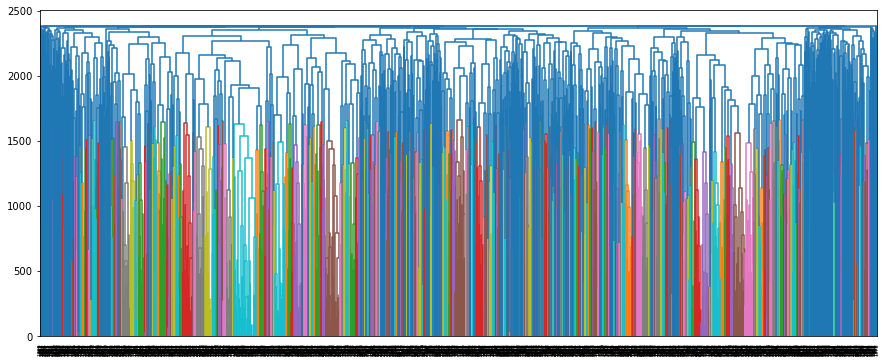

In [58]:
#pass the children to the plot
plot_dend(agg_clusterer.children_)

### Topic Models

<center>
    <h5>Latent Dirichlet Allocation</h5>
 <img src = https://upload.wikimedia.org/wikipedia/commons/4/4d/Smoothed_LDA.png />
</center>

In [59]:
#import
from sklearn.decomposition import LatentDirichletAllocation

In [65]:
#custom class
class LDATopics(BaseEstimator, TransformerMixin):
    
    def __init__(self, ntopics = 10):
        self.ntopics = ntopics
        self.model = make_pipeline(CountVectorizer(stop_words='english', max_features = 100),
                                  LatentDirichletAllocation(n_components = self.ntopics))
        
    def fit_transform(self, documents):
        self.model.fit_transform(documents)
        return self.model
    
    def get_topics(self, n = 15):
        vectorizer = self.model.named_steps['countvectorizer']
        model = self.model.named_steps['latentdirichletallocation']
        
        words = vectorizer.get_feature_names()
        topics = dict()
        
        for idx, topic in enumerate(model.components_):
            features = topic.argsort()[:-(n-1):-1]
            tokens = [words[i] for i in features]
            topics[idx] = tokens
            
        return topics

In [66]:
#fit_transform method
topic_model = LDATopics()

In [67]:
#get_topics method
topic_model.fit_transform(X)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=100, stop_words='english')),
                ('latentdirichletallocation', LatentDirichletAllocation())])

In [68]:
#instantiate
topic_model.get_topics()

{0: ['car',
  'cars',
  'edu',
  'don',
  'like',
  'writes',
  'article',
  'just',
  'subject',
  'lines',
  'people',
  'organization',
  'good'],
 1: ['games',
  'vs',
  'team',
  'season',
  '00',
  'play',
  'game',
  'new',
  'hockey',
  'division',
  'league',
  'power',
  'toronto'],
 2: ['ca',
  'hockey',
  'team',
  'nhl',
  'players',
  'subject',
  'lines',
  'writes',
  'organization',
  'university',
  'play',
  'player',
  'teams'],
 3: ['com',
  'article',
  'writes',
  'subject',
  'organization',
  'lines',
  'posting',
  'host',
  'nntp',
  'like',
  'reply',
  'distribution',
  'just'],
 4: ['year',
  'right',
  'left',
  'got',
  'good',
  'time',
  'just',
  'years',
  'didn',
  'going',
  'did',
  'second',
  'way'],
 5: ['edu',
  'subject',
  'organization',
  'lines',
  'host',
  'nntp',
  'posting',
  'university',
  'article',
  'writes',
  'cc',
  'cs',
  'state'],
 6: ['game',
  'don',
  'think',
  'edu',
  'good',
  'team',
  'players',
  'baseball',
  'b

In [ ]:
#get topics


### Latent Semantic Analysis


Visualization [here](https://upload.wikimedia.org/wikipedia/commons/transcoded/7/70/Topic_model_scheme.webm/Topic_model_scheme.webm.480p.vp9.webm#t=00:00:01,00:00:17.600).

In [ ]:
#add to class above


### Non-Negative Matrix Factorization

![](https://upload.wikimedia.org/wikipedia/commons/f/f9/NMF.png)

In [ ]:
#add to class above


### Visualizing Topic Models 

In [70]:
#!pip install pyldavis

In [71]:
#create vectors
tf_vect = TfidfVectorizer(stop_words='english', max_features=200)
dtm = tf_vect.fit_transform(X)

In [72]:
#fit topic model
lda = LatentDirichletAllocation(n_components=4, random_state=22)
lda.fit(dtm)

LatentDirichletAllocation(n_components=4, random_state=22)

In [73]:
#prepare with pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [74]:
pyLDAvis.sklearn.prepare(lda, dtm, tf_vect)

/Users/jacobkoehler/opt/anaconda3/envs/for_ds/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.014226 -0.117050       1        1  40.564430
2     -0.054355  0.015337       2        1  25.010625
3     -0.101469  0.048973       3        1  17.785731
1      0.141598  0.052741       4        1  16.639214, topic_info=             Term        Freq       Total Category  logprob  loglift
94         hockey   61.000000   61.000000  Default  30.0000  30.0000
50            car  101.000000  101.000000  Default  29.0000  29.0000
75            edu  324.000000  324.000000  Default  28.0000  28.0000
174          team   89.000000   89.000000  Default  27.0000  27.0000
126           nhl   43.000000   43.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
132  organization   35.836652  138.744927   Topic4  -3.8015   0.4397
124           new   21.754250   85.703756   Topic4  -4.3006   0.4223
184           usa   18.772164   65.034968   Topic4  -4.4481   0.5509
55            com   21.758917  227.871485   Topic4  -4.3004  -0.5554
36        article   18.265005  138.689918   Topic4  -4.4755  -0.2338

[218 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         4  0.976740      00
1         1  0.317823      10
1         2  0.158911      10
1         3  0.052970      10
1         4  0.459077      10
...     ...       ...     ...
197       4  0.073477  writes
198       1  0.191847    year
198       2  0.541687    year
198       3  0.225703    year
198       4  0.045141    year

[476 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])